# Author Stefan Panev

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Stefan\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
keeling = pd.read_csv('keeling.csv',error_bad_lines=False)

In [4]:
cols = ['Yr', 'Mn', 'Date', 'Date1', 'CO2', 'seasonally',
       'fit', 'seasonally', 'filled_CO2', 'filled_seasonally']

In [5]:
keeling.columns = cols

In [6]:
keeling = keeling.iloc[2:]

In [7]:
keeling.head()

,Yr,Mn,Date,Date1,CO2,seasonally,fit,seasonally,filled_CO2,filled_seasonally
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.70,314.42,316.19,314.90,315.70,314.42
5,1958,04,21290,1958.2877,317.46,315.15,317.30,314.98,317.46,315.15
6,1958,05,21320,1958.3699,317.51,314.71,317.85,315.06,317.51,314.71


In [8]:
co2 = keeling[['Yr','CO2']]

In [9]:
co2 = co2[co2['CO2'] != '   -99.99']

In [10]:
co2 = pd.to_numeric(co2['CO2'])

In [11]:
train_set = co2.iloc[:711]

In [12]:
test_set = co2.iloc[711:]

In [13]:
def next_batch(training_data,batch_size,steps):
    
    # start from a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [14]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.01
num_train_iterations = 4000
batch_size = 1
num_layers = 3
keep_prob = 0.5

We now place a keep_prob value for the dropout rate and number of layers, to see some hyperparameter tuning.

In [15]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
keep_prob = tf.placeholder_with_default(0.5, shape=())

In [16]:
cells = [tf.contrib.rnn.LSTMCell(num_units=num_neurons)
         for layer in range(num_layers)] 
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)

In [17]:
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [18]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, num_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, num_outputs)
outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_optimizer = optimizer.minimize(loss)

In [20]:
init = tf.global_variables_initializer()

In [21]:
saver = tf.train.Saver()

In [22]:
error = []
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_set,batch_size,num_time_steps)
        sess.run(training_optimizer, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            error.append(mse)
    
    # Save Model for Later
    saver.save(sess, "./StackedLSTM")

0 	MSE: 99100.19
100 	MSE: 58148.863
200 	MSE: 41532.04
300 	MSE: 7545.854
400 	MSE: 1095.6884
500 	MSE: 426.7322
600 	MSE: 490.6097
700 	MSE: 1751.7125
800 	MSE: 662.9793
900 	MSE: 1037.7886
1000 	MSE: 1566.2809
1100 	MSE: 1157.9972
1200 	MSE: 536.193
1300 	MSE: 855.5153
1400 	MSE: 3705.9944
1500 	MSE: 717.6702
1600 	MSE: 555.56055
1700 	MSE: 1400.7787
1800 	MSE: 1354.1672
1900 	MSE: 2406.747
2000 	MSE: 506.20364
2100 	MSE: 1201.4667
2200 	MSE: 1635.6685
2300 	MSE: 3422.7986
2400 	MSE: 632.57666
2500 	MSE: 955.649
2600 	MSE: 1550.4064
2700 	MSE: 1000.4812
2800 	MSE: 699.9777
2900 	MSE: 1811.4614
3000 	MSE: 783.7507
3100 	MSE: 847.1494
3200 	MSE: 932.54517
3300 	MSE: 1675.8651
3400 	MSE: 910.73267
3500 	MSE: 620.35126
3600 	MSE: 1582.0612
3700 	MSE: 650.01056
3800 	MSE: 939.35675
3900 	MSE: 827.1469


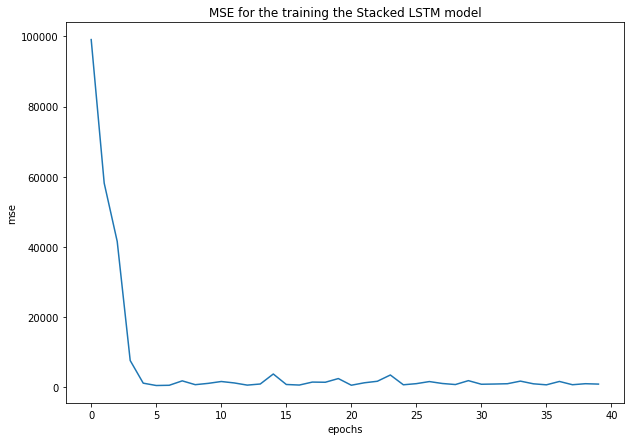

In [23]:
plt.figure(figsize=(10,7))
plt.plot(error)
plt.title('MSE for the training the Stacked LSTM model')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

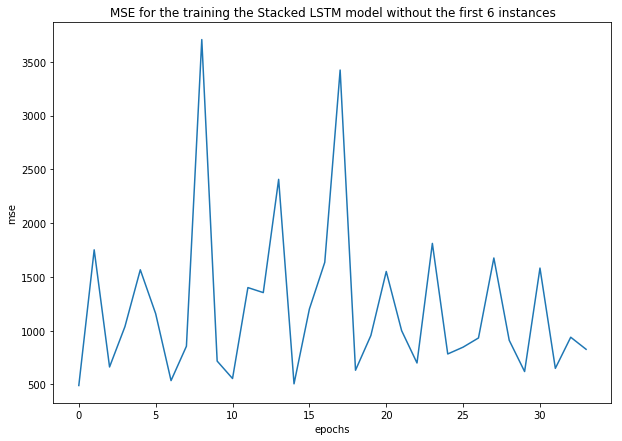

In [24]:
plt.figure(figsize=(10,7))
plt.plot(error[6:])
plt.title('MSE for the training the Stacked LSTM model without the first 6 instances')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

In [25]:
with tf.Session() as sess:
    
    saver.restore(sess, "./StackedLSTM")

    train_seed = list(train_set[-12:])
    
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./StackedLSTM


In [26]:
train_seed

[403.64,
 404.55,
 406.07,
 406.64,
 407.06,
 408.95,
 409.91,
 409.12,
 407.2,
 405.24,
 403.27,
 403.64,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075,
 358.89075]

In [27]:
gen2 = train_seed[12:]

In [28]:
test_copy = test_set.copy(deep=True)

In [29]:
test_copy = pd.DataFrame(test_copy)

In [30]:
test_copy['Generated2'] = gen2

In [31]:
test_copy

,CO2,Generated2
720,405.17,358.890747
721,406.75,358.890747
722,408.05,358.890747
723,408.34,358.890747
724,409.26,358.890747
725,410.31,358.890747
726,411.31,358.890747
727,410.88,358.890747
728,408.90,358.890747
729,407.10,358.890747


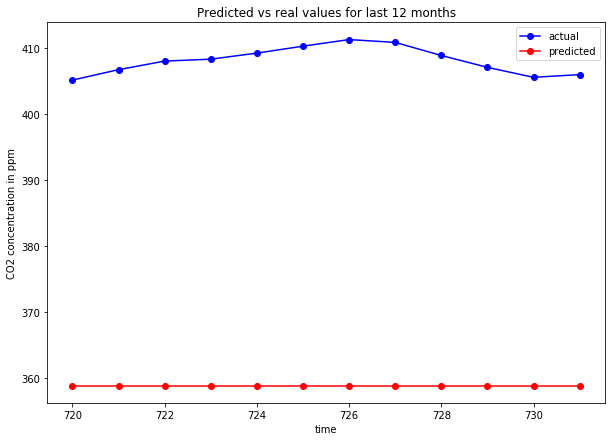

In [32]:
plt.figure(figsize=(10,7))
plt.plot(test_copy['CO2'], marker='o', color='blue', label='actual')
plt.plot(test_copy['Generated2'], marker='o', color='red', label='predicted')
plt.legend(loc='upper right') 
plt.title('Predicted vs real values for last 12 months')
plt.xlabel('time')
plt.ylabel('CO2 concentration in ppm')
plt.show()

The model generates the same values and it is the worst of the used models so far. It does not capture the seasonality nor is it close to the values. 